In [1]:
# ------------------------------------------------------------------------------
#                     TP :  Graph Mining
# ------------------------------------------------------------------------------
# Auteurs: Boubacar Sow
# Date: 21 October 2023
# Version: 1.0
# Description: Graph mining
# ------------------------------------------------------------------------------


In [2]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 2- Analyzing a Real-world Graph

### 2.1 Load Graph and Simple statistics - Task 1

In [3]:
# Loading the graph using networkx

G = nx.read_edgelist("../datasets/CA-HepTh.txt", comments='#', delimiter='\t', create_using=nx.Graph(), nodetype=int, data=False, edgetype=None, encoding='utf-8')

In [4]:
# Number of nodes and edges of the graph G
print("Number of nodes: ", G.number_of_nodes())

print("Number of edges: ", G.number_of_edges())

Number of nodes:  9877
Number of edges:  25998


### 2.2 Connected Components

In [5]:
# NUmber of connected componnents using the connected_components function

print("Number of connected components: ", nx.number_connected_components(G))

# Is the graph connected or not?
print("Is the graph connected? ", nx.is_connected(G))

#Largest connected component subgraph
largest_cc = max(nx.connected_components(G), key=len) # This is a set
print(largest_cc)

# Number of nodes and edges of the largest connected component
print("Number of nodes of the largest connected component: ", G.subgraph(largest_cc).number_of_nodes()) # All the elements within a set are distinct

# Number of edges
print("Number of edges of the largest connected component: ", G.subgraph(largest_cc).number_of_edges())

Number of connected components:  429
Is the graph connected?  False
{1, 32773, 5, 32780, 16, 65553, 20, 65562, 30, 32800, 65568, 65570, 32803, 65571, 38, 39, 44, 32814, 32815, 32817, 65586, 32832, 32833, 32834, 32838, 65615, 65617, 65618, 65619, 65621, 65622, 65624, 32856, 65626, 65627, 32860, 32863, 32864, 97, 65634, 65631, 65647, 32881, 65650, 65651, 116, 65661, 65662, 129, 65665, 136, 32905, 32911, 32916, 65687, 65688, 32924, 65692, 159, 32928, 65697, 165, 32935, 32939, 65707, 175, 65711, 176, 177, 179, 178, 181, 183, 189, 190, 65727, 192, 65729, 195, 65734, 215, 216, 223, 32992, 230, 233, 240, 242, 243, 245, 249, 65786, 65788, 65792, 33029, 65797, 33030, 33036, 65805, 273, 65814, 279, 33048, 33047, 278, 65818, 290, 65826, 33060, 33063, 296, 65832, 65834, 33067, 300, 65833, 302, 303, 33072, 305, 65842, 65847, 65848, 65857, 33090, 65859, 33092, 33093, 33091, 65864, 33097, 33099, 65868, 334, 33103, 33104, 33105, 338, 65880, 65882, 352, 354, 65891, 356, 65893, 65895, 360, 361, 362, 363

### 2.3 Analysis of the Degree Distribution of the Graph

In [6]:
# Extraction of degree sequence of the graph
degree_sequence = [G.degree (node) for node in G.nodes()]

# Minimum, maximum, median and mean degree of the nodes of the graph
minimum = np.min(degree_sequence)
maximum = np.max(degree_sequence)
median = np.median(degree_sequence).round().astype('int')
mean = np.mean(degree_sequence).round().astype('int')

print("Minimum degree: ", minimum)
print("Maximum degree: ", maximum)
print("Median degree: ", median)
print("Mean degree: ", mean)


Minimum degree:  1
Maximum degree:  65
Median degree:  3
Mean degree:  5


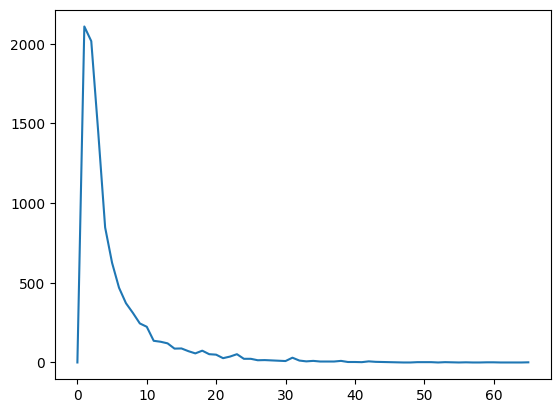

In [7]:
# Plot the degree histogram using matplotlib.pyplot, use the degree_histogram()
degree_hist = nx.degree_histogram(G)
plt.plot(degree_hist)

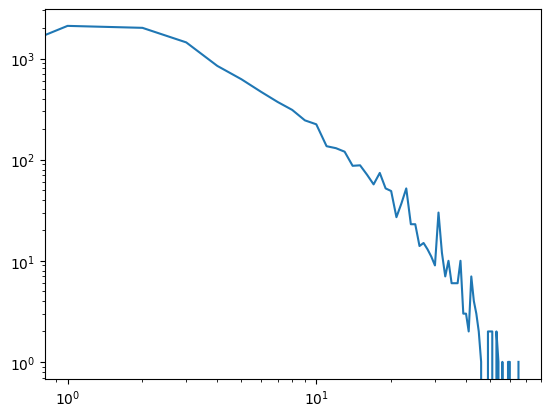

In [8]:
# Same plot but log-log axis
plt.loglog(degree_hist)

### 2.4 Clustering Coefficient

In [9]:
# Calculating the global clustering coefficient of the HepTh graph
# The global clustering coefficient is defined based on triplets of nodes. A triplet of nodes, which
# is connected by two edges is called an open triplet. A triplet of nodes, which is connected by three edges is called a 
# closed triplet or a triangle. The global clustering coefficient is the number of closed triplets divided by the number of both open and closed triplets
# Use the transitivity function in NetworkX

print("Global clustering coefficient: ", nx.transitivity(G))


Global clustering coefficient:  0.2839996525875546


# Community Detection

### 3.1 Spectral Clustering - Task 6 and 7

In [10]:
############## Task 6
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
    
    # Adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G)
    D_inv = diags([1/G.degree(node) for node in G.nodes()])

    Lrw = eye(G.number_of_nodes()) - D_inv @ adjacency_matrix

    eigen_values, eigen_vectors = eigs(Lrw, k=k, which='SR')

    eigen_vectors = np.real(eigen_vectors)

    kmeans = KMeans(n_clusters=k).fit(eigen_vectors)

    clustering = {}

    for i, node in enumerate(G.nodes()):
        clustering[node] = kmeans.labels_[i]
    return clustering

The eigenvectors corresponding to the k-smallest eigenvalues are indicators for connected component-ness of the graph.

In [11]:
import warnings
warnings.filterwarnings("ignore")
clusters = spectral_clustering(G, 50)

#### 3.2 Modularity

In [12]:
def modularity(graph, clustering):
    
    total_edges = graph.number_of_edges()
    # Initializing modularity
    modularity = 0
    # Iterating over each community in the clustering
    for community in set(clustering.values()):
        community_nodes = [node for node in graph.nodes() if clustering[node] == community]
        intra_community_edges = graph.subgraph(community_nodes).number_of_edges()
        total_degree = sum([graph.degree(node) for node in community_nodes])
        modularity += intra_community_edges / total_edges - (total_degree / (2 * total_edges)) ** 2

    return modularity


In [13]:
# Modularity between the clustering results obtained through spectral clustering
# and a obtained if we randomly partition the nodes into 50 clusters (assign a node to a cluster using randint(a, b) function in this case)

def random_clustering(G, k):
    clustering = {}
    for node in G.nodes():
        clustering[node] = np.random.randint(0, k)
    return clustering
random_clustering = random_clustering(G, 50)

modularity_random = modularity(G, random_clustering)
modularity_spectral = modularity(G, clusters)

In [14]:
print(modularity_random)
print(modularity_spectral)


0.0009839916141892143
0.0857729675229741


## 4 Graph Classification using Graph Kernels

### 4.1 Dataset Generation

In [15]:
"""
Graph Mining - ALTEGRAD - Oct 2023
"""

import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Graph classification using graph kernels

############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    # Generating 100 cycle graphs and 100 path graphs
    for i in range(3, 103):
        # Generate a cycle graph and append it to the list of graphs
        G_cycle = nx.cycle_graph(i)
        Gs.append(G_cycle)
        y.append(0)  

        # Generate a path graph and append it to the list of graphs
        G_path = nx.path_graph(i)
        Gs.append(G_path)
        y.append(1) 

    return Gs, y


In [16]:
Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test





### 4.2 Implementation of Graphlet Kernel

In [82]:
import numpy as np
import networkx as nx
import random

def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    # Define the four types of size-3 graphlets (triangles)
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)                 

    def sample_graphlets(G, n_samples):
        counts = np.zeros(4)
        for _ in range(n_samples):
            sampled_nodes = np.random.choice(G.nodes(), 3)
            subgraph = nx.subgraph(G, sampled_nodes)
            for i, graphlet in enumerate(graphlets):
                if nx.is_isomorphic(subgraph, graphlet):
                    counts[i] += 1
        return counts

    phi_train = np.zeros((len(Gs_train), 4))
    for i, G in enumerate(Gs_train):
        phi_train[i] = sample_graphlets(G, n_samples)

    phi_test = np.zeros((len(Gs_test), 4))
    for i, G in enumerate(Gs_test):
        phi_test[i] = sample_graphlets(G, n_samples)

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

In [83]:
############## Task 12
K_train_gk, K_test_gk = graphlet_kernel(G_train, G_test, n_samples=200)


### 4.3 Graph Classification using SVM

In [84]:
############## Task 13

from sklearn.svm import SVC

clf = SVC(kernel='precomputed')
clf.fit(K_train_sp, y_train)
y_pred_sp = clf.predict(K_test_sp)
    
clf2 = SVC(kernel='precomputed')
clf2.fit(K_train_gk, y_train)
y_pred_gk = clf2.predict(K_test_gk)

In [89]:
from sklearn.metrics import accuracy_score

accuracy_sp = accuracy_score(y_pred_sp, y_test)
accuracy_gk = accuracy_score(y_pred_gk, y_test)

print("Accuracy shortest path: ", accuracy_sp)
print("Accuracy graphlet kernel: ", accuracy_gk)

Accuracy shortest path:  1.0
Accuracy graphlet kernel:  0.65
